## Etape 4 : Simulez un Contrat de Maintenance

##### Import des librairies :

In [2]:
# standard libraries import
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import time
from datetime import timedelta

# Machine Learning libraries import
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA

In [3]:
%matplotlib inline
# palette clusters colors
clusters_palette = {
    -1: "#808080",
    0: "#66c2a5",
    1: "#fc8d62",
    2: "#8da0cb",
    3: "#e78ac3",
    4: "#a6d854",
    5: "#ffd92f",
    6: "#e5c494",
    7: "#b3b3b3",
}

**Stratégie de la démarche pour fixer un délai de maintenance :**

1. Analyser la stabilité des clusters (ARI : Adjusted Rand Index) et définir un seuil en dessous duquel le modèle doit être réentraîné.
2. Analyse de l'évolution des distributions des features pour s'assurer qu'elles ne changent pas trop et que le modèle reste pertinent.
3. Recommandation de réévaluation périodique.


##### Fonctions

In [4]:
def calculate_kolmogorov(df1, df2, col):
    """
    calculate kolgomorov-smirnov tests
    if dataframes aren't empty
    and display results
    Parameters:
    df1 (pd.DataFrame): First DataFrame to compare.
    df2 (pd.DataFrame): Second DataFrame to compare.
    col (str): feature to compare
    """
    if df1[col].empty or df2[col].empty:
        return 0, 0
    ks_statistic, p_value = stats.ks_2samp(df1[col], df2[col])
    #print(f"Statistics KS for {col} : {ks_statistic}, p-value: {p_value}")
    return ks_statistic, p_value

def plot_correlation_circle(pc_x, pc_y, title, x_label, y_label, 
                            loadings_df, list_names):
    """Display correlation circle from PCA"""
    
    plt.figure(figsize=(6, 6))

    # circle definition
    circle = plt.Circle((0, 0), 1, facecolor="none", 
                        edgecolor="b", linestyle="--")
    plt.gca().add_artist(circle)

    # projection vectors with names
    for i in range(len(loadings_df)):
        plt.arrow(
            0,
            0,
            loadings_df.iloc[i, pc_x],
            loadings_df.iloc[i, pc_y],
            head_width=0.05,
            head_length=0.05,
            linewidth=0.5,
            color="black",
        )
        plt.text(
            loadings_df.iloc[i, pc_x] * 1.15,
            loadings_df.iloc[i, pc_y] * 1.15,
            list_names[i],
            color="red",
            ha="center",
            va="center",
        )

    # graphic parameters
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.axhline(0, color="grey", lw=0.5)
    plt.axvline(0, color="grey", lw=0.5)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.gca().set_aspect("equal")  
    plt.grid(False)

    plt.show()

def RFM_satisfaction__graph(df, titre):
    """Display a RFM scatterplot from dataframe"""
    
    df = (
        df.groupby('cluster')
        .agg({'frequence':'mean', 
              'recence':'mean', 
              'sum_payments':'mean', 
              'mean_review_score':'mean'})
        .reset_index()
    )
    
    sizes = df['mean_review_score'] * 300

    # graph figure
    plt.figure(figsize=(10, 6))

    # scatter plot
    scatter = plt.scatter(
        df['recence'], 
        df['frequence'], 
        s=sizes, 
        c=df['mean_review_score'], 
        cmap='viridis', 
        alpha=0.7, 
        edgecolors="w", 
        linewidth=2
    )

    # cluster
    for i in range(df.shape[0]):
        plt.text(
            df['recence'][i], 
            df['frequence'][i], 
            f'Cluster {df["cluster"][i]}', 
            fontsize=9, 
            ha='right', 
            va='bottom'
        )

    # labels and title
    plt.xlabel("Recence (months since last order)")
    plt.ylabel('Frequence')
    plt.title(f"RFM Analysis with satisfaction for {titre} model")

    # color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Satisfaction')

    # point size legend
    from matplotlib.lines import Line2D
    handles = [
        Line2D([0], [0], marker='o', color='w', label='Low Payments', 
               markerfacecolor='gray', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='High Payments', 
               markerfacecolor='gray', markersize=20)
    ]
    plt.legend(handles=handles, title='Monetary Value Scale')
    
    plt.grid(True)
    plt.show()

#####  

---
---
### 4.1 - Analyse de la stabilité des clusters :

Pour analyser l'évolution du clustering nous allons utiliser le **score ARI** (Adjusted Rand Index), qui évalue le nombre de paires d'éléments qui sont classés de manière similaire ou différente entre deux partitions.  
Dans le contexte de segmentation de clients pour **Olist**, où l'on veut garder une bonne stabilité du clustering afin de garder des actions marketing efficaces, **le seuil de score acceptable est déterminé à : 0,8**.

Méthode
---
---
**Soit la fonction de calcul :**  

*ari_score = adjusted_rand_score(clusters_t1, clusters_t2)*  

On commence par entrainer le modèle de base `model_0` (KMeans) sur un dataset `X_0` sur une période d'1 an la plus récente :  
**model_0.fit(X_0)**  ==> cluster_0

Avec :  
``model_0`` -> le modèle de base entrainé  
``X_0`` -> le fichier d'entrainement (1an de données)  
``cluster_0`` -> le clustering obtenu  

On réalise une prédiction à partir du `model_0` d'un dataset d'une période d'1 an décalé d'1 semaine dans le temps `W_1` :  
**cluster_1_init = model_0.predict(W_1)**  

Avec :  
``model_0`` -> le modèle de base entrainé  
``W_1`` -> le dataset d'1 an  décalé d'1 semaine    
``cluster_1_init`` -> le clustering obtenu par un predict du M0 (sera **clusters_t1** du ari_score)

On entraine le dataset `W_1` sur un nouveau modèle KMeans afin d'avoir le clustering tel qu'il serait :  
**model_1.fit(W_1)**  ==> **cluster_1_new**

Avec :  
``model_1`` -> Nouveau KMeans entrainé avec W_1  
``W_1`` -> le dataset d'1 an  décalé d'1 semaine  
``cluster_1_new`` -> le clustering obtenu par un fit du M1 (sera **clusters_t2** du ari_score)


---
---

##### Importation du dataset :

In [5]:
# import dataset
df = pd.read_csv("data/cleaned/final_dataset_labels.csv")

---
#### 4.1.1 - Préparation du dataset :

Les features nécessaires sont :
* ``frequence``
* ``recence``
* ``recence_date`` (pour filtrer le dataframe)
* ``sum_payments``
* ``mean_review_score``

In [6]:
# delete features
df = df.drop(columns=[
    'customer_unique_id',
    'count_category_purchased',
    'qty_seller',
    'order_received',
    'order_not_received',
    'order_in_time',
    'order_late',
    'customer_city',
    'avg_days_between_orders',
    'cluster',
])

In [7]:
# transform feature to datetime
df["recence_date"] = pd.to_datetime(df["recence_date"])

In [8]:
df.dtypes

frequence                     int64
recence                     float64
recence_date         datetime64[ns]
sum_payments                float64
mean_review_score           float64
dtype: object

---
#### 4.1.2 - Dataframe d'entrainement du modèle de base :

In [9]:
# sort dataframe by date most recent to older
df_train = df.sort_values(by='recence_date', ascending=False)

In [10]:
# searching most recent date and calculate 1 year period
date_max = df_train['recence_date'].max()
date_one_year = date_max - pd.DateOffset(years=1)

In [11]:
# create dataframe 1 year long to train first model
df_train = df_train.loc[df_train['recence_date'] >= date_one_year]

In [12]:
df_train.columns

Index(['frequence', 'recence', 'recence_date', 'sum_payments',
       'mean_review_score'],
      dtype='object')

In [13]:
X_0 = df_train.drop(columns=['recence_date'])

In [27]:
X_0.shape

(71921, 4)

---
#### 4.1.3 - Réalisation d'un Pipeline :

In [15]:
# defining columns types
quantitative_features = ["frequence", "recence", "mean_review_score"]
log_transform_features = ["sum_payments"]

In [16]:
# standardscaler transformer
quantitative_transformer = Pipeline([("scaler", StandardScaler())])

# logarithm transformer
log_transformer = Pipeline(
    [("log_transform", FunctionTransformer(np.log1p, validate=True))]
)

# pipeline logarithm transform and standardscaler
log_and_scale_transformer = Pipeline(
    [("log_transform", log_transformer), ("scaler", StandardScaler())]
)

# full preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("quant", quantitative_transformer, quantitative_features),
        ("log_and_scale", log_and_scale_transformer, log_transform_features),
    ]
)

In [17]:
# kmeans pipeline
pipeline_kmeans = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("kmeans", 
         KMeans(n_clusters=4, init="k-means++", n_init=1, random_state=42)
        )
    ]
)

---
#### 4.1.4 - Entrainement du `model_0` : 

In [18]:
# fit pipeline and time
start_time = time.time()
model_0 = pipeline_kmeans.fit(X_0)
end_time = time.time()
print("Model fitting time : {:.2f} s".format(end_time - start_time))

Model fitting time : 0.13 s


#### 4.1.5 - Analyse du clustering de départ avec le `model_0` :

In [19]:
# retrieve labels from pipeline
cluster_0 = model_0.named_steps["kmeans"].labels_
# apply preprocessing
X_0_transformed = model_0.named_steps["preprocessor"].transform(X_0)

In [20]:
# pca
pca = PCA(n_components=2)
principal_components_0 = pca.fit_transform(X_0_transformed)
df_pca_model_0 = pd.DataFrame(
    data=principal_components_0, columns=["PC1", "PC2"]
)
df_pca_model_0["cluster"] = cluster_0

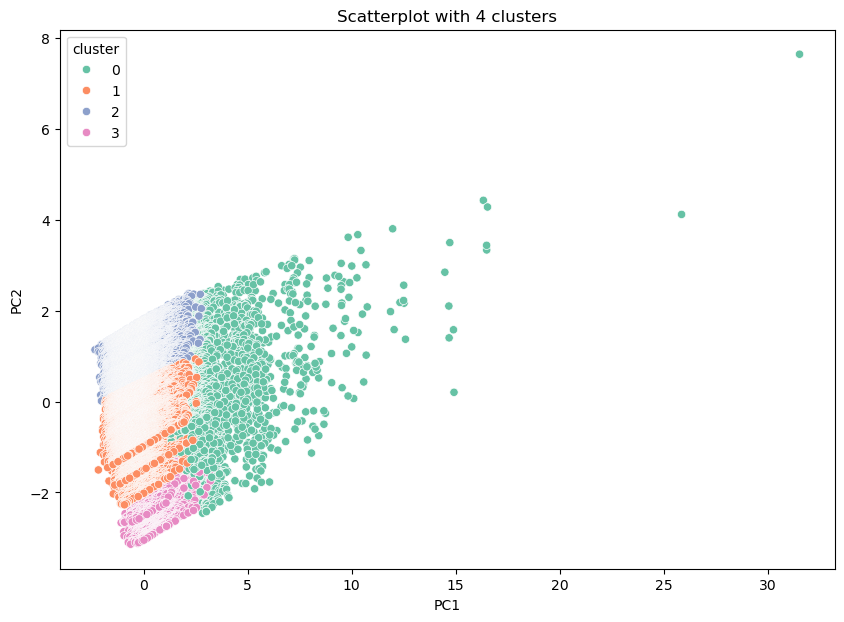

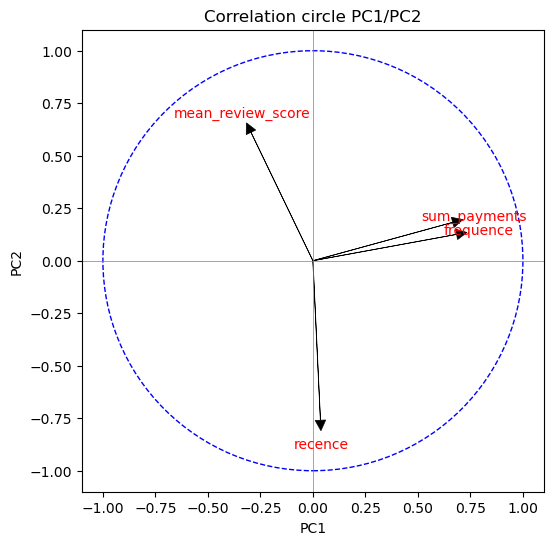

In [21]:
# clustering scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="cluster", 
    data=df_pca_model_0, 
    palette=clusters_palette
)
plt.title(f"Scatterplot with 4 clusters")
plt.show()

# pca correlation circle 
features_list_names = quantitative_features + log_transform_features
components = pca.components_

loadings_df = pd.DataFrame(
    components.T,
    columns=[f"PC{i+1}" for i in range(components.shape[0])],
    index=features_list_names,
)

plot_correlation_circle(
    0, 
    1, 
    "Correlation circle PC1/PC2", 
    "PC1", 
    "PC2", 
    loadings_df, 
    features_list_names
)

In [22]:
# dataframe for statistics
data_X_0 = X_0.copy()
data_X_0["cluster"] = cluster_0
# clustering statistic descriptive 
data_X_0_summary = data_X_0.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
        "mean_review_score": ["mean", "median", "std"],
    }
)
data_X_0_summary

frequence                             recence                      \
            count      mean median      std      mean    median       std   
cluster                                                                     
0            4058  2.206752    2.0  0.63687  5.670715  5.486202  3.262882   
1           26568  1.000000    1.0  0.00000  8.752707  8.869908  1.691208   
2           29485  1.000000    1.0  0.00000  2.924189  2.890933  1.630939   
3           11810  1.000000    1.0  0.00000  6.109858  6.110381  2.710585   

        sum_payments                     mean_review_score                   
                mean  median         std              mean median       std  
cluster                                                                      
0         264.830956  202.72  234.557991          3.710747    4.0  1.478570  
1         137.758786   92.57  169.402143          4.627597    5.0  0.598283  
2         152.169525   99.90  209.313499          4.667729    5.0  0.571616  
3         159.779182  101.34  212.962515          1.565284    1.0  0.799174

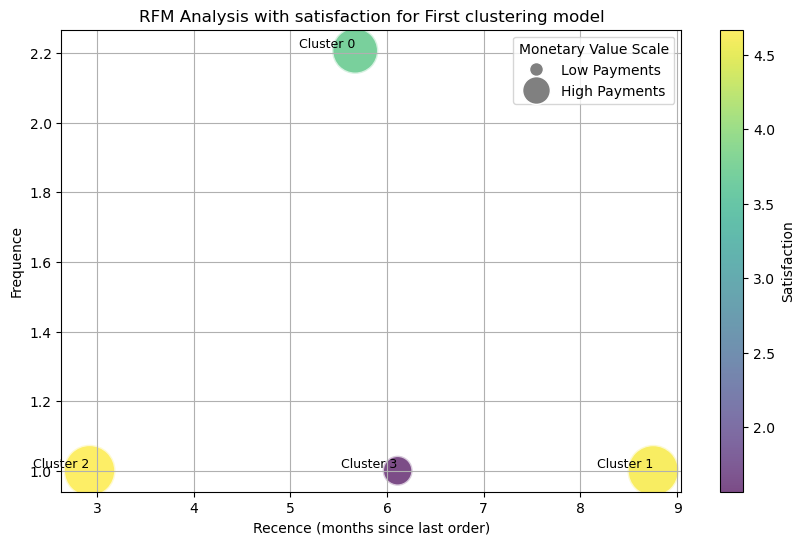

In [23]:
# display RFM representation
RFM_satisfaction__graph(data_X_0, 'First clustering')

**Profiling :**

* Cluster 0 : "Nouveaux clients très satisfaits"
* Cluster 1 : "Clients petits budgets non satisfaits"
* Cluster 2 : "Clients fidèles moyennement satisfaits"
* Cluster 3 : "Clients inactifs mais satisfaits"

---
#### 4.1.6 - Calcul et affichage du Score ARI :

In [28]:
# prepare new dataframe 
df_test = df.copy()
df_test = df_test.sort_values(by='recence_date')

In [29]:
df_test.describe()

,frequence,recence,recence_date,sum_payments,mean_review_score
count,93396.000000,93396.000000,93396,93396.000000,93396.000000
mean,1.066288,7.941664,2018-01-03 23:48:03.407287296,154.516834,4.104500
min,1.000000,0.000000,2016-09-04 21:15:19,9.590000,1.000000
25%,1.000000,3.876478,2017-09-16 21:42:42.249999872,59.407500,4.000000
50%,1.000000,7.293035,2018-01-23 13:21:13,101.140000,5.000000
75%,1.000000,11.530880,2018-05-07 21:24:43,171.830000,5.000000
max,15.000000,23.915900,2018-09-03 09:06:57,7571.630000,5.000000
std,0.312979,5.031693,NaN,206.137697,1.324574


##### Boucle de calcul du score ARI :

In [30]:
# create temp list
df_ari_score = []
# search most recent date and calculate 1 year period
start_date = df_test['recence_date'].max()
end_date = start_date - pd.DateOffset(years=1)

# predictions of all the dataset on model_0
cluster_init = model_0.predict(df_test.drop(columns=['recence_date']))

# number of iteration
weeks = 52

# loop to calculate ARI score
for i in range(weeks):
    # select period and filter dataframe by a mask
    mask = (
        df_test['recence_date'] <= start_date) & (
        df_test['recence_date'] > end_date
        )
    df_sample = df_test[mask].drop(columns=['recence_date'])

    # fit new model
    model_1 = pipeline_kmeans.fit(df_sample)
    cluster_1_new = model_1.named_steps["kmeans"].labels_

    # calculate ARI score
    ari_score = adjusted_rand_score(cluster_1_new, cluster_init[mask])
    # append temp list
    df_ari_score.append([i+1, ari_score])
    
    # move period for a week
    start_date -= timedelta(weeks=1)
    end_date = start_date - pd.DateOffset(years=1)

    # dataframe at T0 + 6 weeks, and labels
    if i == 5:
        X_limit = df_sample.copy()
        cluster_limit = cluster_1_new
        cluster_init_limit = cluster_init[mask]

# transform temp list ARI score to dataframe
df_ari_score = pd.DataFrame(df_ari_score, columns=['week', 'ari_score'])

##### Affichage de l'évolution du score ARI dans le temps :

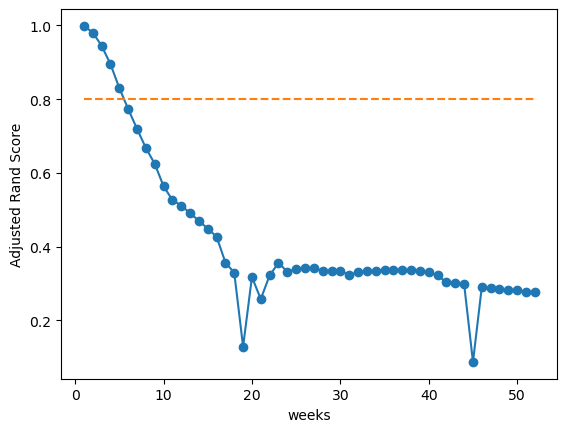

In [31]:
# add a limit line to 0.8
df_ari_score['limit'] = 0.8

# ARI graph with limit line
fig, ax = plt.subplots()
ax.plot(df_ari_score['week'], df_ari_score['ari_score'], marker="o")
ax.plot(df_ari_score['week'], df_ari_score['limit'], linestyle='--')
ax.set_xlabel("weeks")
ax.set_ylabel("Adjusted Rand Score")
fig.show()

##### Tableau des scores ARI (10 premiers résultats) :

In [32]:
df_ari_score.head(10)

,week,ari_score,limit
0,1,0.998576,0.8
1,2,0.980462,0.8
2,3,0.944798,0.8
3,4,0.894912,0.8
4,5,0.830295,0.8
5,6,0.773432,0.8
6,7,0.719753,0.8
7,8,0.667857,0.8
8,9,0.625017,0.8
9,10,0.564480,0.8


**Commentaires :**  

A la semaine 6, le score ARI passe en dessous le seuil déterminé :  
* **0.77** pour 0.8 défini

---
#### 4.1.7 - Analyse de l'évolution du clustering :

Analyse à T0 + 6 semaines au moment ou le score ARI passe sous la valeur limite de 0.8  
Soit le dataset nommé W_6, comparaison entre les statistiques descriptives des clusters :
* cluster_init_model_0 = model_0.predict(W_6)
* cluster_new_model_1 = model_1.fit(W_6)
  

(le dataframe et les labels ont été récupérés dans la boucle FOR)

**cluster_init_model_0 :**

In [33]:
# apply preprocessing
X_init_limit_transformed = model_0.named_steps["preprocessor"].transform(X_limit)

In [34]:
# dataframe for statistics
data_X_init_limit = X_limit.copy()
data_X_init_limit["cluster"] = cluster_init_limit
# clustering statistic descriptive 
data_X_init_limit_summary = data_X_init_limit.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
        "mean_review_score": ["mean", "median", "std"],
    }
)

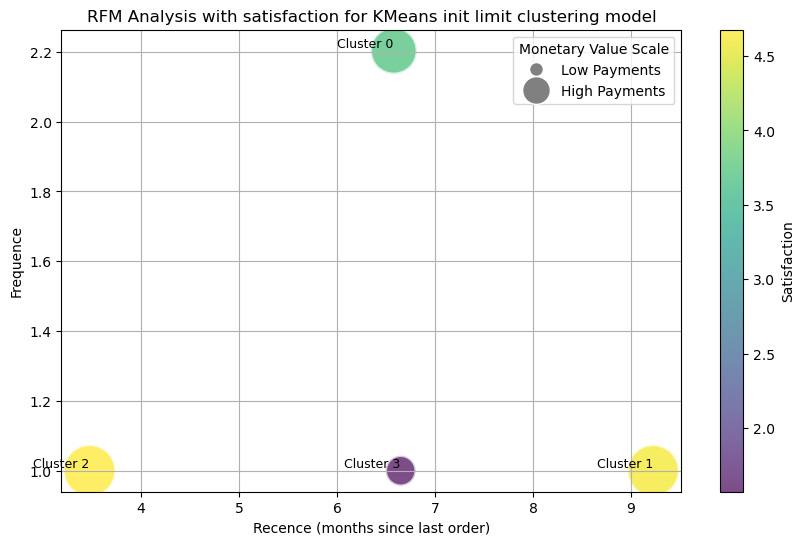

In [35]:
# display RFM representation
RFM_satisfaction__graph(data_X_init_limit, 'KMeans init limit clustering')

**cluster_new_model_1 :**

In [36]:
# apply preprocessing
X_limit_transformed = model_1.named_steps["preprocessor"].transform(X_limit)

In [37]:
# dataframe for statistics
data_X_limit = X_limit.copy()
data_X_limit["cluster"] = cluster_limit
# clustering statistic descriptive 
data_X_limit_summary = data_X_limit.groupby("cluster").agg(
    {
        "frequence": ["count", "mean", "median", "std"],
        "recence": ["mean", "median", "std"],
        "sum_payments": ["mean", "median", "std"],
        "mean_review_score": ["mean", "median", "std"],
    }
)

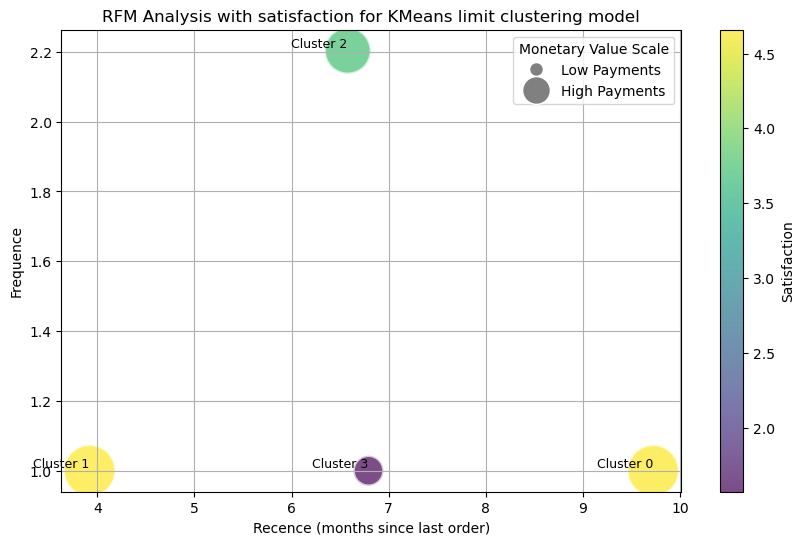

In [38]:
# display RFM representation
RFM_satisfaction__graph(data_X_limit, 'KMeans limit clustering')

**Comparaison des statistiques descriptives :**

In [39]:
data_X_init_limit_summary

frequence                              recence                      \
            count      mean median       std      mean    median       std   
cluster                                                                      
0            3907  2.203225    2.0  0.598821  6.578551  6.406045  3.262219   
1           30357  1.000000    1.0  0.000000  9.227328  9.165572  2.023981   
2           23601  1.000000    1.0  0.000000  3.473051  3.580815  1.340891   
3           11601  1.000000    1.0  0.000000  6.649167  6.307490  2.680778   

        sum_payments                     mean_review_score                   
                mean  median         std              mean median       std  
cluster                                                                      
0         263.929839  199.40  241.773191          3.719114    4.0  1.474240  
1         138.576712   92.30  170.314668          4.626577    5.0  0.602048  
2         154.100136  101.50  210.923575          4.676878    5.0  0.558367  
3         160.718529  101.73  212.899057          1.572192    1.0  0.803000

In [40]:
data_X_limit_summary

frequence                              recence                      \
            count      mean median       std      mean    median       std   
cluster                                                                      
0           25660  1.000000    1.0  0.000000  9.724188  9.428384  1.779356   
1           28310  1.000000    1.0  0.000000  3.920215  3.909330  1.604056   
2            3907  2.203225    2.0  0.598821  6.578551  6.406045  3.262219   
3           11589  1.000000    1.0  0.000000  6.792175  6.537451  2.663876   

        sum_payments                      mean_review_score                   
                mean   median         std              mean median       std  
cluster                                                                       
0         138.579315   92.265  169.814950          4.635581    5.0  0.594783  
1         151.368283   99.900  205.285551          4.659661    5.0  0.574452  
2         263.929839  199.400  241.773191          3.719114    4.0  1.474240  
3         161.101466  102.140  212.685427          1.570714    1.0  0.802100

**Commentaires :**  
*Attention l'odre des clusters n'est pas le même entre les 2 dataframes.*

* Le cluster `"Clients fidèles moyennement satisfaits"` n'a pas changé entre les 2 segmentations.
* Le cluster `"Clients petits budgets non satisfaits"` : légère modification de la récence, ce qui modifie légèrement le nombre points (0.5%)
* Le cluster `"Clients inactifs mais satisfaits"` : Changements significatifs du nombre de points (-17%), avec évolutions de la récence et montant
* Le cluster `"Nouveaux clients très satisfaits"`: Changements significatifs du nombre de points (+20%), avec évolutions de la récence et montant

---
#### 4.1.8 - Interprétation :

Le paramètre qui fait principalement baisser le score ARI est un déplacement de points entre les clusters :
* `"Clients inactifs mais satisfaits"`
* `"Nouveaux clients très satisfaits"`
qui est principalement du à la récence.

---
---
### 4.2 -  Analyse de l'évolution des distributions des features :

#### 4.2.1 - Stratégie :

Analyse de l'évolution des distributions des features dans le temps par 2 méthodes :
* Tests de Kolmogorov-Smirnov (calculs par glissement d'1 semaine)
* Evolution graphique des distributions par boxplots (évolution mensuelle)

---
#### 4.2.2 - Test de Kolmogorov-Smirnov :

Préparation des données et calculs :

In [36]:
# create a dateframe to record Kolgomorov values
df_kolmogorov = pd.DataFrame(columns=[
    "feature",
    "dataset_1", 
    "qty_cust_dataset_1", 
    "dataset_2", 
    "qty_cust_dataset_2", 
    "ks_value", 
    "p_value"
])

##### Boucle de tests KS :

In [37]:
# first period to test
start_date = df_test['recence_date'].max()
end_date = start_date - pd.DateOffset(years=1)
# second period to test - shift 1 week
start_date_2 = start_date - timedelta(weeks=1)
end_date_2 = start_date_2 - pd.DateOffset(years=1)

# number of iteration
weeks = 52

# loop to calculate kolmogorov tests
for i in range(weeks):
    label1 = f"sample {i+1}"
    label2 = f"sample {i+2}"
    # select first period and filter dataframe by a mask
    mask_1 = (df_test['recence_date'] <= start_date
             ) & (
                 df_test['recence_date'] > end_date
             )
    df_sample_1 = df_test[mask_1].drop(columns=['recence_date'])
    # select second period and filter dataframe by a mask
    mask_2 = (df_test['recence_date'] <= start_date_2
             ) & (
                 df_test['recence_date'] > end_date_2
             )
    df_sample_2 = df_test[mask_2].drop(columns=['recence_date'])

    # calculate for each feature
    for col in df_sample_1.columns:
        ks_statistic, p_value = calculate_kolmogorov(df_sample_1, 
                                                     df_sample_2, 
                                                     col)
        df_kolmogorov.loc[len(df_kolmogorov)] = [col, label1, 
                                                 len(df_sample_1), 
                                                 label2, 
                                                 len(df_sample_2), 
                                                 ks_statistic, 
                                                 p_value]
    
    # shifting periods for 1 week
    start_date -= timedelta(weeks=1)
    end_date = start_date - pd.DateOffset(years=1)
    start_date_2 = start_date - timedelta(weeks=1)
    end_date_2 = start_date_2 - pd.DateOffset(years=1)

##### Boucle de récupération des dataframes par mois (boxplots)

In [38]:
# distributions
df_distributions_recence = pd.DataFrame()
df_distributions_monetary_value = pd.DataFrame()
df_distributions_frequence = pd.DataFrame()
df_distributions_satisfaction = pd.DataFrame()

start_date = df_test['recence_date'].max()
end_date = start_date - pd.DateOffset(years=1)

# number of iteration
weeks = 12

# loop to retrieve monthly distribution
for i in range(weeks):
    # select first period and filter dataframe by a mask
    mask_1 = (df_test['recence_date'] <= start_date) & (df_test['recence_date'] > end_date)
    df_sample_1 = df_test[mask_1].drop(columns=['recence_date'])
    df_distributions_recence[i+1] = df_sample_1['recence']
    df_distributions_monetary_value[i+1] = df_sample_1['sum_payments']
    df_distributions_frequence[i+1] = df_sample_1['frequence']
    df_distributions_satisfaction[i+1] = df_sample_1['mean_review_score']
    
    # shifting periods for 4 weeks
    start_date -= timedelta(weeks=4)
    end_date = start_date - pd.DateOffset(years=1)

#####  

In [39]:
df_kolmogorov

,feature,dataset_1,qty_cust_dataset_1,dataset_2,qty_cust_dataset_2,ks_value,p_value
0,frequence,sample 1,71921,sample 2,72740,0.000058,1.000000e+00
1,recence,sample 1,71921,sample 2,72740,0.012772,1.491328e-05
2,sum_payments,sample 1,71921,sample 2,72740,0.000694,1.000000e+00
3,mean_review_score,sample 1,71921,sample 2,72740,0.000667,1.000000e+00
4,frequence,sample 2,72740,sample 3,72498,0.000068,1.000000e+00
...,...,...,...,...,...,...,...
203,mean_review_score,sample 51,23490,sample 52,22421,0.000206,1.000000e+00
204,frequence,sample 52,22421,sample 53,21589,0.000137,1.000000e+00
205,recence,sample 52,22421,sample 53,21589,0.037197,1.168767e-13
206,sum_payments,sample 52,22421,sample 53,21589,0.001637,1.000000e+00


##### Préparation des données par features :

In [40]:
# create dataframes by features 
df_recence = df_kolmogorov.loc[df_kolmogorov['feature'] == 'recence']
df_monetary_value = df_kolmogorov.loc[
df_kolmogorov['feature'] == 'sum_payments'
]
df_frequence = df_kolmogorov.loc[df_kolmogorov['feature'] == 'frequence']
df_satisfaction = df_kolmogorov.loc[
df_kolmogorov['feature'] == 'mean_review_score'
]

---
#### 4.2.3 - Feature `recence` :

**Test Kolmogorov-Smirnov par semaine :**

Text(0.5, 1.0, 'Kolmogorov-Smirnov Tests by week')

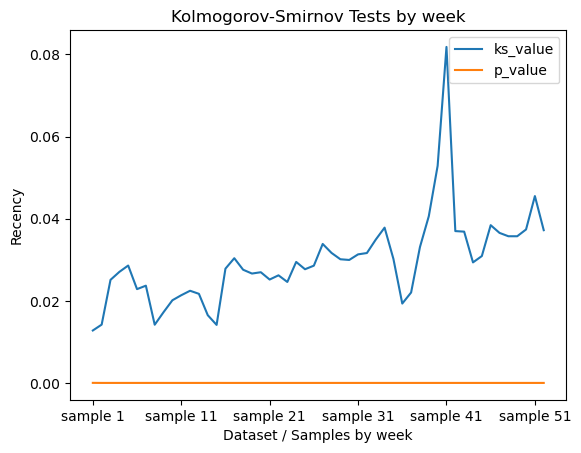

In [56]:
ax = df_recence.plot.line(x='dataset_1', y=[ 'ks_value', 'p_value'])
ax.set_xlabel('Dataset / Samples by week') 
ax.set_ylabel('Recency')
ax.set_title('Kolmogorov-Smirnov Tests by week')

**Commentaires :**  
Grandes variations du test KS dans le temps sur le graphique, qui reste toutefois sur une échelle très modeste (de 0.015 à 0.08).  
Cela montre une évolution des valeurs certaines, mais dans de petites proportions.  
Le p-value proche de 0 rejète l'hypothèse nulle, donc les distributions sont différentes.

**Distributions par mois :**

Text(0.5, 1.0, 'Evolution of Recency Distributions by Month')

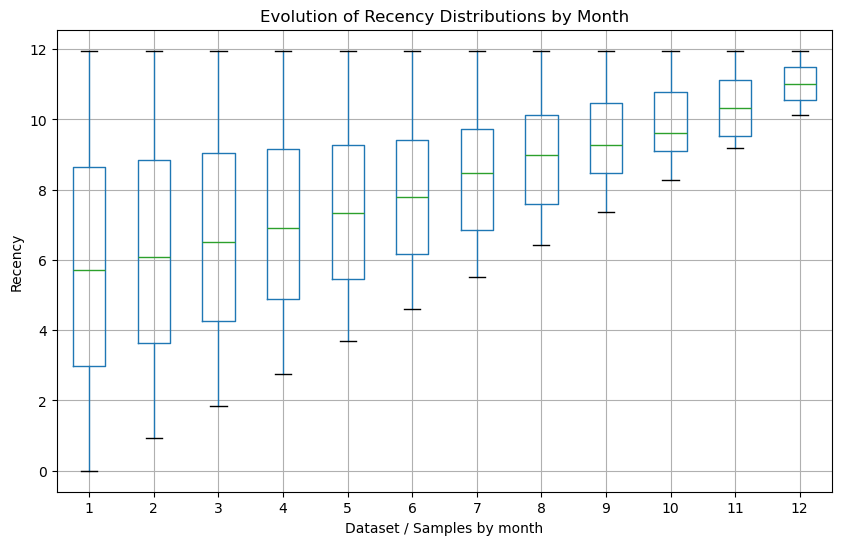

In [57]:
ax = df_distributions_recence.boxplot(figsize=(10,6))
ax.set_xlabel('Dataset / Samples by month') 
ax.set_ylabel('Recency')
ax.set_title('Evolution of Recency Distributions by Month')

**Commentaires :**  
Evolution visible tous les mois, de façon linéaire.

---
#### 4.2.4 - Feature `monetary_value` :

**Test Kolmogorov-Smirnov par semaine :**

Text(0.5, 1.0, 'Kolmogorov-Smirnov Tests by week')

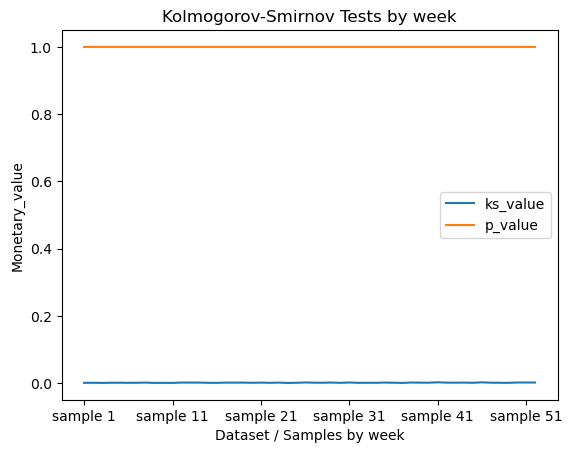

In [59]:
ax = df_monetary_value.plot.line(x='dataset_1', y=[ 'ks_value', 'p_value'])
ax.set_xlabel('Dataset / Samples by week') 
ax.set_ylabel('Monetary_value')
ax.set_title('Kolmogorov-Smirnov Tests by week')

**Commentaires :**  
Les valeurs KS proches de 0 et le p_value proche de 1 nous indique que les distributions sont stables dans le temps (peu de différence maximale dans les distributions).

**Distribution par mois :**

Text(0.5, 1.0, 'Evolution of Monetary_value Distributions by Month')

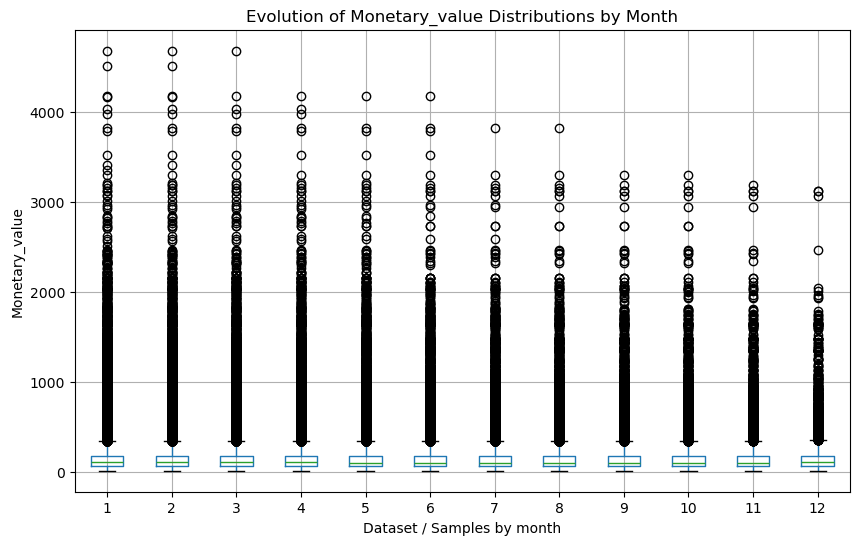

In [53]:
ax = df_distributions_monetary_value.boxplot(figsize=(10,6))
ax.set_xlabel('Dataset / Samples by month') 
ax.set_ylabel('Monetary_value')
ax.set_title('Evolution of Monetary_value Distributions by Month')

**Commentaires :**  
Les box n'évoluent pas dans le temps, seuls les points (outliers) évolent légèrement chaque mois, ce qui n'impacte pas les tests KS.

#### 4.2.5 - Feature `frequence` :

**Test Kolmogorov-Smirnov par semaine :**

Text(0.5, 1.0, 'Kolmogorov-Smirnov Tests by week')

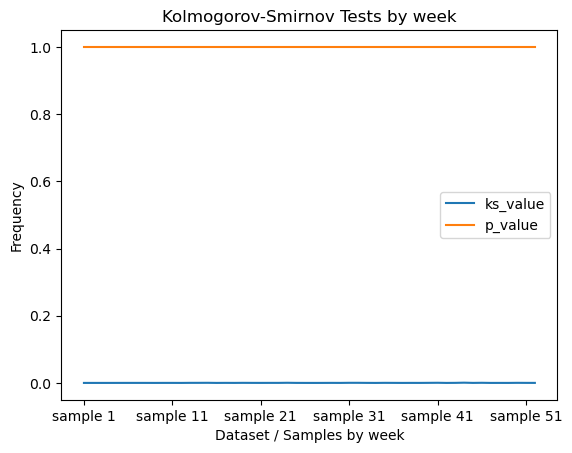

In [60]:
ax = df_frequence.plot.line(x='dataset_1', y=[ 'ks_value', 'p_value'])
ax.set_xlabel('Dataset / Samples by week') 
ax.set_ylabel('Frequency')
ax.set_title('Kolmogorov-Smirnov Tests by week')

**Commentaires :**  
Les valeurs KS proches de 0 et le p_value proche de 1 nous indique que les distributions sont stables dans le temps (peu de différence maximale dans les distributions).

**Distributions par mois :**

Text(0.5, 1.0, 'Evolution of Frequency Distributions by Month')

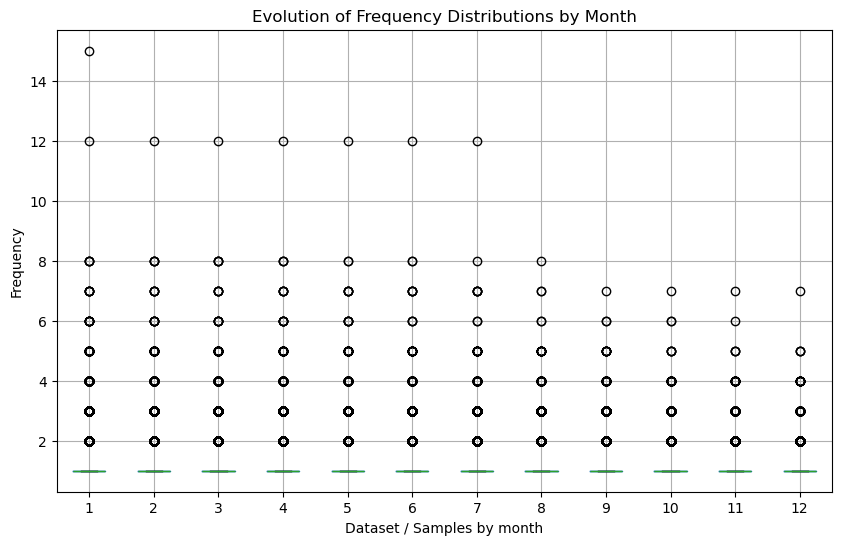

In [54]:
ax = df_distributions_frequence.boxplot(figsize=(10,6))
ax.set_xlabel('Dataset / Samples by month') 
ax.set_ylabel('Frequency')
ax.set_title('Evolution of Frequency Distributions by Month')

**Commentaires :**  
Les box n'évoluent pas dans le temps, seuls les points (outliers) évolent légèrement chaque mois, ce qui n'impacte pas les tests KS.

#### 4.2.6 - Feature `satisfaction` :

**Test Kolmogorov-Smirnov par semaine :**

Text(0.5, 1.0, 'Kolmogorov-Smirnov Tests by week')

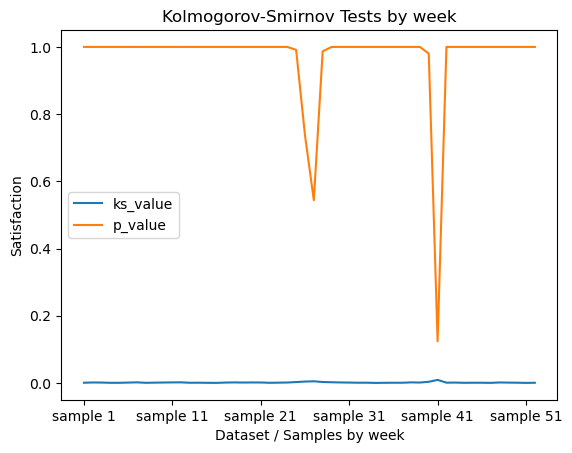

In [61]:
ax = df_satisfaction.plot.line(x='dataset_1', y=[ 'ks_value', 'p_value'])
ax.set_xlabel('Dataset / Samples by week') 
ax.set_ylabel('Satisfaction')
ax.set_title('Kolmogorov-Smirnov Tests by week')

**Commentaires :**  
Très légère variations de la valeur KS à Week_27 et week_41 que l'on peut constater avec le p_value qui chute drastiquement mais dans des ordres > 0.05%.  
Il est très probable que des évolutions des distributions est lieue tout de même à ces périodes.

**Distributions par mois :**

Text(0.5, 1.0, 'Evolution of Satisfaction Distributions by Month')

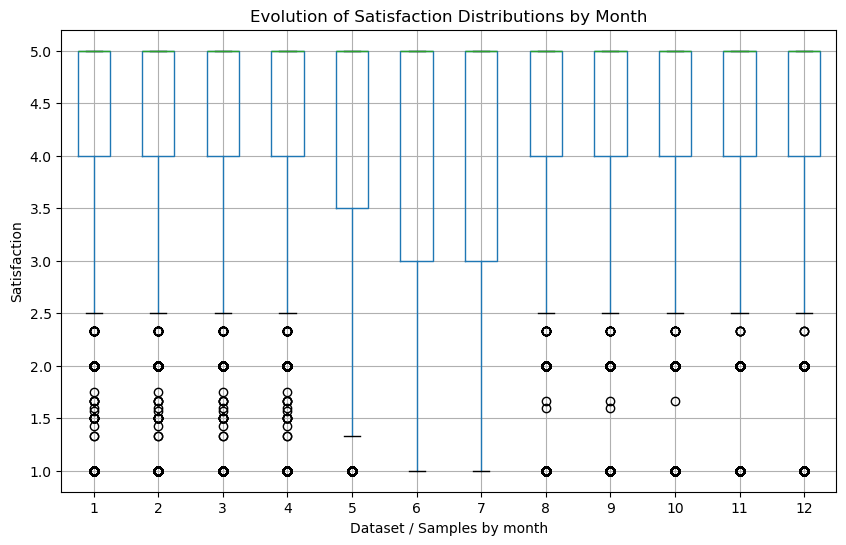

In [51]:
ax = df_distributions_satisfaction.boxplot(figsize=(10,6))
ax.set_xlabel('Dataset / Samples by month') 
ax.set_ylabel('Satisfaction')
ax.set_title('Evolution of Satisfaction Distributions by Month')

**Commentaires :**  
Pas d'évolutions visibles les 4 premiers mois.  
Une évolution visible de la distribution à partir du 5ème mois, une autre au 8ème mois.  
Légères évolutions des outliers entre les mois 9 et 12.

#### 4.1.7 - Interprétation :

Les distributions des features `monetary_value` et `frequence` varient peu ou suffisamment peu dans le temps pour avoir des valeurs de KS très basses. Ces features ont peu d'influence sur le ARI Score.  
La feature `satisfaction` montre des évolutions de distribution à partir du 5ème mois pour revenir à la normal au 8ème, ce qui montre une période moins satisfaisante (sujet à évoquer aux équipes d'Olist pour approfondissement).  
La feature `recence` évolue elle de façon linéaire dans le temps, c'est la principale cause de la baisse du ARI Score.

---
---
### 4.3 Recommandation de mise à jour segmentation :

Afin de garder une segmentation pertinente, **l'Adjusted Rand Index** ainsi que l'évolution des distributions des features nous permettent de déterminer une fréquence adéquate.  
En prenant en compte un seuil de l'ARI à 0.8, je recommande une mise à jour de la segmentation toutes les 5 semaines.